In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data import Dataset 
import torch.nn.utils as utils
import time
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import Levenshtein as lev
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

import seaborn as sns
import random

In [2]:
LETTER_LIST = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
               'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', \
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', \
               '3', '4', '5', '6', '7','8', '9', '-', "'", '.', '_', '+', ',', '?', '!', '[', ']', '=', '(', \
               ')', ':', '/', '"', ' ', '<eos>']

In [3]:
print(len(LETTER_LIST))

81


In [4]:
!nvidia-smi

Thu Apr 29 04:24:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   31C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
def create_dictionaries(letter_list):
    letter2index = {}
    index2letter = {}
    for i in range(0,len(letter_list)):
        letter2index[letter_list[i]]=i
        index2letter[i]=letter_list[i]
    
    return letter2index, index2letter

letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [6]:
df = pd.read_table("knnw_en_sub.csv", sep = ";", header=0)
idx_text = []
for i in range(df.shape[0]):
    text = df.iloc[i][3]
    split_text = text.split()
    
    l = []
    for word in split_text:
        for c in word:
            if c == 'é':
                c = 'e'
            if c == "“" or c == "”":
                c = '"'
            l.append(letter2index[c])
        l.append(letter2index[' '])#Space between the words use letter2index
    l=l[:-1]
    l.append(letter2index['<eos>'])#End of the sentence
    idx_text.append(l)
df['idx_text'] = idx_text
print(df.head())
    

   Number  Start time in milliseconds  End time in milliseconds  \
0       1                        1650                     10800   
1       2                       53940                     58090   
2       3                       58700                     61440   
3       4                       62060                     66540   
4       5                       66540                     69550   

                                                Text  \
0                                   TOHO CORPORATION   
1  Some mornings, I wake up crying without knowin...   
2      That's when everything happens now and again.   
3  Whatever that dream was I had, I can never rem...   
4                                  - But... - But...   

                                            idx_text  
0  [46, 41, 34, 41, 79, 29, 41, 44, 42, 41, 44, 2...  
1  [45, 15, 13, 5, 79, 13, 15, 18, 14, 9, 14, 7, ...  
2  [46, 8, 1, 20, 64, 19, 79, 23, 8, 5, 14, 79, 5...  
3  [49, 8, 1, 20, 5, 22, 5, 18, 79, 20, 

In [7]:
total_frames=1370582 
total_duration=6396010
duration_per_frame = total_duration / total_frames
audio = np.load("knnw_en.log_spectrogram.npy")

def get_index(time, start_flag):
    if start_flag == True:
        return np.floor(time/duration_per_frame)
        
    else:
        return np.ceil(time/duration_per_frame)
        
def get_range(start_time, end_time):
        
    start_index = get_index(start_time, start_flag=True)
    stop_index  = get_index(end_time, start_flag=False)
        
    return range(int(start_index), int(stop_index))

audio_array = []
for i in range(df.shape[0]):
    
    start_time = df.iloc[i][1]
    stop_time = df.iloc[i][2]
    
    audio_range = get_range(start_time, stop_time)
    audio_item = torch.as_tensor(audio[:,audio_range]).float().permute(1,0)
    audio_array.append(audio_item)
print(len(audio_array))
    

1393


In [8]:
class Speech2TextDataset(Dataset):
    '''
    Dataset class for the speech to text data, this may need some tweaking in the
    getitem method as your implementation in the collate function may be different from
    ours. 
    '''
    def __init__(self, speech, text=None, isTrain=True):
        self.speech = speech
        self.isTrain = isTrain
        if (text is not None):
            self.text = text

    def __len__(self):
        return len(self.speech)

    def __getitem__(self, index):
        if (self.isTrain == True):
            return self.speech[index], torch.tensor(self.text[index])
        else:
            return self.speech[index]

def collate_train(batch_data):
    #This batch will contain the speech,speech len and the text,text len
    ### Return the padded speech and text data, and the length of utterance and transcript ###
    X=[]
    Xlen=[]
    Y=[]
    Ylen=[]
    #print("Length of batch data :",len(batch_data))
    for i in range(len(batch_data)):
#         X.append(torch.tensor(batch_data[i][0]))
        X.append(batch_data[i][0])
        Xlen.append(len(batch_data[i][0]))
#         Y.append(torch.tensor(batch_data[i][1]))
        Y.append(batch_data[i][1])
        Ylen.append(len(batch_data[i][1]))
        
    Xpad=pad_sequence(X, batch_first=True)#(B, T, C) 
    Ypad=pad_sequence(Y, batch_first=True)#(B, T, C) 
    
    return Xpad,torch.tensor(Xlen),Ypad,torch.tensor(Ylen)

def collate_test(batch_data):
    ### Return padded speech and length of utterance ###
    X=[]
    Xlen=[]
    for i in range(len(batch_data)):
        X.append(torch.tensor(batch_data[i]))
        Xlen.append(torch.tensor(len(batch_data[i])))
        #print(len(batch_data[i]))
        
    Xpad=pad_sequence(X, batch_first=True)
    
    return Xpad,torch.tensor(Xlen)


In [10]:
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 11785

In [51]:
# Creating data indices for training and validation splits:
dataset_size = len(audio_array)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [54]:
train_dataset = Speech2TextDataset(audio_array[split:], idx_text[split:])
valid_dataset = Speech2TextDataset(audio_array[:split], idx_text[:split])
print(len(train_dataset))
print(len(valid_dataset))

1115
278


In [55]:



# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_train,num_workers=8,pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_train,num_workers=8,pin_memory=True)


# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler,collate_fn=collate_train,num_workers=8,pin_memory=True)
# valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler,collate_fn=collate_train,num_workers=8,pin_memory=True)

In [56]:
len(train_loader)

70

In [57]:
len(valid_loader)

18

In [58]:
from torch.autograd import Variable
class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        # x': (B, L, C)
        if dropout == 0 or not self.training:
            return x
        mask = x.data.new(x.size(0), 1, x.size(2))
        mask = mask.bernoulli_(1 - dropout)
        mask = Variable(mask, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        
        return mask * x

In [59]:
class Attention(nn.Module):
    '''
    Attention is calculated using key, value and query from Encoder and decoder.
    Below are the set of operations you need to perform for computing attention:
        energy = bmm(key, query)
        attention = softmax(energy)
        context = bmm(attention, value)
    '''
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, query, key, value, lens):
        '''
        :param query :(batch_size, hidden_size) Query is the output of LSTMCell from Decoder
        :param keys: (batch_size, max_len, encoder_size) Key Projection from Encoder
        :param values: (batch_size, max_len, encoder_size) Value Projection from Encoder
        :return context: (batch_size, encoder_size) Attended Context
        :return attention_mask: (batch_size, max_len) Attention mask that can be plotted 
        
        '''
        #print('query type :',type(query))
        # Compute (batch_size, max_len) attention logits. "bmm" stands for "batch matrix multiplication".
        # Input shape of bmm:  (batch_size, max_len, hidden_size), (batch_size, hidden_size, 1) 
        # Output shape of bmm: (batch_size, max_len, 1)
        #print("Shape of key:",key.shape)
        attention = torch.bmm(key, query.unsqueeze(2)).squeeze(2)
        
        
        # Create an (batch_size, max_len) boolean mask for all padding positions
        # Make use of broadcasting: (1, max_len), (batch_size, 1) -> (batch_size, max_len)
        mask = torch.arange(key.size(1)).unsqueeze(0) >= lens.unsqueeze(1)
        mask=mask.to(device)
        # Set attention logits at padding positions to negative infinity.
        attention.masked_fill_(mask, -1e9)
        
        # Take softmax over the "source length" dimension.
        attention = nn.functional.softmax(attention, dim=1)
        
        # Compute attention-weighted sum of context vectors
        # Input shape of bmm: (batch_size, 1, max_len), (batch_size, max_len, hidden_size) 
        # Output shape of bmm: (batch_size, 1, hidden_size)
        context = torch.bmm(attention.unsqueeze(1), value).squeeze(1)
        
        # attention vectors are returned for visualization
        return context, attention
        


In [60]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    The length of utterance (speech input) can be hundereds to thousands of frames long.
    The Paper reports that a direct LSTM implementation as Encoder resulted in slow convergence,
    and inferior results even after extensive training.
    The major reason is inability of AttendAndSpell operation to extract relevant information
    from a large number of input steps.
    '''
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.0):
        super(pBLSTM, self).__init__()
        self.blstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1,dropout=dropout_rate, bidirectional=True,batch_first=True)
        self.lockdrop = LockedDropout()
        self.dropout=dropout_rate

    def forward(self, x):
        '''
        :param x :(N, T) input to the pBLSTM
        :return output: (N, T, H) encoded sequence from pyramidal Bi-LSTM 
        '''
        #First we unpack the sequence
        x_pad,x_len=utils.rnn.pad_packed_sequence(x,batch_first=True)

        x_pad = self.lockdrop(x_pad, self.dropout)
        x_pad=x_pad[:,:(x_pad.shape[1]//2)*2,:]
        
        x_pad = x_pad.contiguous().view(x_pad.shape[0],int(x_pad.shape[1]//2),x_pad.shape[2]*2)        

        #print("Shape of output after x_pad :",x_pad.shape)
        x_len=x_len//2

        #Now we pack this back to send it off to the LSTM
        x_pack = utils.rnn.pack_padded_sequence(x_pad, lengths=x_len, batch_first=True, enforce_sorted=False)

        output, _ = self.blstm(x_pack)
        
        return output

In [61]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key and value.
    Key and value are nothing but simple projections of the output from pBLSTM network.
    '''
    def __init__(self, input_dim, hidden_dim, value_size=128,key_size=128,dropout_rate=0.0,dropouti=0):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=256, num_layers=1, bidirectional=True,batch_first=True)
        #print("hidden dimension is :",hidden_dim)
        
        ### Add code to define the blocks of pBLSTMs! ###
        self.pBLSTM1=pBLSTM(hidden_dim*4, hidden_dim,dropout_rate=dropout_rate)#Can change it to 2
        self.pBLSTM2=pBLSTM(hidden_dim*4, hidden_dim,dropout_rate=dropout_rate)
        self.pBLSTM3=pBLSTM(hidden_dim*4, hidden_dim,dropout_rate=dropout_rate)
        
        #print(hidden_dim)
        #print(type(hidden_dim)
        
        self.key_network = nn.Linear(hidden_dim*2, value_size)
        self.value_network = nn.Linear(hidden_dim*2, key_size)
        
        self.dropout=dropouti
        self.lockdrop = LockedDropout()


    def forward(self, x, lens):
        #print("X shape :",x.shape)
        #print(lens)
        rnn_inp = utils.rnn.pack_padded_sequence(x, lengths=lens, batch_first=True, enforce_sorted=False)
        outputs, _ = self.lstm(rnn_inp)
        
        outputs=self.pBLSTM1(outputs)#We get a packed sequence output 
        outputs=self.pBLSTM2(outputs)#We get a packed sequence output 
        outputs=self.pBLSTM3(outputs)#We get a packed sequence output 
        
        linear_input,encoder_lens = utils.rnn.pad_packed_sequence(outputs,batch_first=True)
        
        linear_input = self.lockdrop(linear_input, self.dropout)
        keys = self.key_network(linear_input)
        value = self.value_network(linear_input)

        return keys, value,encoder_lens


In [62]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step, 
    thus we use LSTMCell instead of LSLTM here.
    The output from the second LSTMCell can be used as query here for attention module.
    In place of value that we get from the attention, this can be replace by context we get from the attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, hidden_dim, value_size=128, key_size=128, isAttended=True):#isAttended was set to false originally
        super(Decoder, self).__init__()
        hidden_dim=key_size + value_size
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=letter2index['<eos>'])#b,max_len,hidden_decoder
        self.lstm1 = nn.LSTMCell(input_size=768, hidden_size=256)#512,512
        self.lstm2 = nn.LSTMCell(input_size=256, hidden_size=key_size)#Why is this key size
        
        
        self.isAttended = isAttended
        if (isAttended == True):
            self.attention = Attention()

        self.character_prob = nn.Linear(key_size + value_size, vocab_size)
        self.value_size=value_size 
        self.embedding.weight=self.character_prob.weight
        
        
        self.fc1 = nn.Linear(256, 256)
        self.selu1 = nn.SELU()
#         #self.bn1 = nn.BatchNorm1d(256)
        self.selu2 = nn.SELU()
#         #self.bn2 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 256)
        
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.character_prob.bias.data.zero_()
        self.character_prob.weight.data.uniform_(-initrange, initrange)


    def forward(self, epoch,batch_idx,encoder_lens,teacherForcingRate,key, values, text=None, isTrain=True):
        '''
        :param key :( N,T, key_size) Output of the Encoder Key projection layer
        :param values: (N, T,value_size) Output of the Encoder Value projection layer
        :param text: (N, text_len) Batch input of text with text_length
        :param isTrain: Train or eval mode
        :return predictions: Returns the character perdiction probability 
        '''
        batch_size = key.shape[0]

        if (isTrain == True):
            max_len =  text.shape[1]
            embeddings = self.embedding(text)
        else:
            max_len = 600
            
        total_attention=[]
        predictions = []
        hidden_states = [None, None]
        prediction = torch.zeros(batch_size,1).to(device)#(torch.ones(batch_size, 1)*33).to(DEVICE)
        context = values[:, 0, :].reshape(values.size(0),values.size(2))
        teacherForcingRate=teacherForcingRate 
        
        for i in range(max_len):
            # * Implement Gumble noise and teacher forcing techniques 
            # * When attention is True, replace values[i,:,:] with the context you get from attention.
            # * If you haven't implemented attention yet, then you may want to check the index and break 
            #   out of the loop so you do not get index out of range errors. 
            
            if (isTrain):
                #We consider Teacher forcing at first
                #Then we check if i=0 or not
                tf = np.random.random()
                if tf > teacherForcingRate :
                    if i==0:
                        char_embed=self.embedding(torch.zeros(batch_size,dtype=torch.long).fill_(letter2index['<sos>']).to(device))
                        #print(torch.zeros(batch_size,dtype=torch.long).fill_(letter2index['<sos>']))
                    else:
                        #We use the ground truth
                        char_embed = embeddings[:,i-1,:].to(device)#Dimension is of B,1,hidden_dim
                else:
                    char_embed = self.embedding(prediction.argmax(dim=-1)).to(device)
                    
            else:
                #Then we check if i=0 or not
                if i==0:
                    char_embed=self.embedding(torch.zeros(batch_size,dtype=torch.long).fill_(letter2index['<sos>']).to(device))
                else:
                    #char_embed = torch.nn.functional.gumbel_softmax(prediction).mm(self.embedding.weight)
                    char_embed = self.embedding(prediction.argmax(dim=-1)).to(device)

                
            inp = torch.cat([char_embed, context], dim=1)#Char Embed dim:B,H_ and Context:B,hidden_dim
            hidden_states[0] = self.lstm1(inp, hidden_states[0])

            inp_2 = hidden_states[0][0]
            hidden_states[1] = self.lstm2(inp_2, hidden_states[1])

            ### Compute attention from the output of the second LSTM Cell ###
            output = hidden_states[1][0]
                        
            #if self.isAttended :
            context,masked_attention=self.attention(output,key,values, encoder_lens)
            total_attention.append(masked_attention.detach().cpu())
            
            output = self.selu1(self.fc1(output))
            context = self.selu2(self.fc2(context))
            context = context.to(device)

            prediction = self.character_prob(torch.cat([output, context], dim=1))#Dimension is of B,hidden_dim for context
                                                                                 #Dimension is of B,hidden_dim for context
            predictions.append(prediction.unsqueeze(1))
            
        if batch_idx+1==70:
            
            all_attentions = torch.stack(total_attention, dim=1)
            
            plt.clf()
            
            sns.heatmap(all_attentions[0,:,:], cmap='GnBu')
            plt.show()
            print("all_attentions shape :",all_attentions.shape)
            
#             fig = plt.figure()
#             plt.imshow(all_attentions[0,:,:], cmap="hot")
#             plt.show()
#             #plt.imsave('./attention', fig, cmap='hot')
#             plt.close()
            

        return torch.cat(predictions, dim=1)#This is B,T,Vocab_size

In [63]:
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, hidden_dim, value_size=128, key_size=128, isAttended=True):
        super(Seq2Seq, self).__init__()
        self.dropout_rate=0.2
        self.dropouti=0.2
        self.encoder = Encoder(input_dim,256,256,256,self.dropout_rate,self.dropouti)
        self.decoder = Decoder(vocab_size, hidden_dim,256,256)

    def forward(self, epoch,batch_idx,teacherForcingRate,speech_input, speech_len, text_input=None, isTrain=True):
        key, value, encoder_lens = self.encoder(speech_input, speech_len)
        if (isTrain == True):
            predictions = self.decoder(epoch,batch_idx,encoder_lens,teacherForcingRate,key, value, text_input,isTrain=True)
        else:
            predictions = self.decoder(epoch,batch_idx,encoder_lens,None,key, value, text=None, isTrain=False)
        return predictions

In [64]:
#now we should build the model
print(len(LETTER_LIST))
model = Seq2Seq(input_dim=129, vocab_size=len(LETTER_LIST), hidden_dim=128)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='none')
nepochs = 30

81


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [65]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# checkpoint = torch.load('./checkpoint_final/Model_attention_Final2_52.pth')#Resnet_50_checkpoint
# model.load_state_dict(checkpoint)
model.to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(129, 256, batch_first=True, bidirectional=True)
    (pBLSTM1): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, dropout=0.2, bidirectional=True)
      (lockdrop): LockedDropout()
    )
    (pBLSTM2): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, dropout=0.2, bidirectional=True)
      (lockdrop): LockedDropout()
    )
    (pBLSTM3): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, dropout=0.2, bidirectional=True)
      (lockdrop): LockedDropout()
    )
    (key_network): Linear(in_features=512, out_features=256, bias=True)
    (value_network): Linear(in_features=512, out_features=256, bias=True)
    (lockdrop): LockedDropout()
  )
  (decoder): Decoder(
    (embedding): Embedding(81, 512, padding_idx=80)
    (lstm1): LSTMCell(768, 256)
    (lstm2): LSTMCell(256, 256)
    (attention): Attention()
    (character_prob): Linear(in_features=512, out_features=81, bias=True)
    (fc1): Linear(in_features=256, out_feature

In [66]:
#For predictions
def predictions(pred):
    sentence_full=[]
    for sentence in pred:#Taking every sentence
        sent=''
        for char in sentence:
            if char==80:
                #print(char)
                break
            else:
                sent+=index2letter[char]
        sentence_full.append(sent)
    return sentence_full

In [67]:
#For computing the distance
def LevScore(preds, targets):
    res = 0.0
    for i in range(len(preds)):
        dist = lev.distance(preds[i], targets[i])
        res += dist
        
    return res#Average Levenstein Distance over the batch

In [68]:
def train(model, train_loader, criterion, optimizer, epoch, teacherForcingRate):
    model.train()
    model.to(device)
    
    # 1) Iterate through your loader
    train_loss=0
    
    
    for batch_idx,(inp,inp_len,target,target_len) in enumerate(train_loader):
        start = time.time()
        
        # 2) Use torch.autograd.set_detect_anomaly(True) to get notices about gradient explosion
        
        # 3) Set the inputs to the device.
        inp,inp_len,target=inp.to(device),inp_len.to(device),target.to(device)
        optimizer.zero_grad()
        
        # 4) Pass your inputs, and length of speech into the model.
        output=model(epoch,batch_idx,teacherForcingRate,inp, inp_len, target,True)
        
        mask = torch.arange(max(target_len)).unsqueeze(0) >= target_len.int().unsqueeze(1)#Switching Masks
        mask=mask.to(device)
        #mask = generate_mask(target_len).to(device)

        output.contiguous()
        # 6) If necessary, reshape your predictions and origianl text input 
        # 6.1) Use .contiguous() if you need to. 

        # 7) Use the criterion to get the loss.
        loss=criterion(output.view(-1,output.shape[2]),target.contiguous().view(-1))
        
        # 8) Use the mask to calculate a masked loss. 
        #masked_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask)
        loss.masked_fill_(mask.contiguous().view(-1),0)
        
        loss=loss.mean()
        
        # 9) Run the backward pass on the masked loss. 
        loss.backward()
        # 10) Use torch.nn.utils.clip_grad_norm(model.parameters(), 2)
        torch.nn.utils.clip_grad_norm(model.parameters(), 2)

        # 11) Take a step with your optimizer
        optimizer.step()
        # 12) Normalize the masked loss
        train_loss+=loss.item()

        # 13) Optionally print the training loss after every N batches
        del inp
        del inp_len
        del target
        del target_len
        stop = time.time()
        torch.cuda.empty_cache()
        
        if batch_idx % 10 == 0:
            print('B: %d / %d, avg_loss: %.3f, Time Taken : %.3f, ' % (batch_idx+1, len(train_loader),train_loss/(batch_idx+1),stop-start),end='\n ')
    
#         torch.save(model.state_dict(), "./checkpoint_final/Model_attention_Final2_{}.pth".format(epoch+1))

def validation(model, valid_loader):
    valid_loss=0
    total_dist_score=0
    model.eval()
    seq_len=0
    dist_score=0
    seq_len=0
    
    for batch_idx,(inp,inp_len,target,target_len) in enumerate(valid_loader):
        start = time.time()
        inp,inp_len,target=inp.to(device),inp_len.to(device),target.to(device)
        
        output=model(epoch,batch_idx,None,inp, inp_len, None, False)
        pred=predictions(output.argmax(-1).detach().cpu().numpy())#We get back batch of characters
        target=predictions(target.detach().cpu().numpy())#We get back batch of characters
        

        dist_score+= LevScore(pred,target)
        seq_len+=len(pred)#This is the batch size
        
        del inp
        del inp_len
#         del target
        del target_len
        stop = time.time()
        torch.cuda.empty_cache()
    print("prediciton :",pred[0])
    print("Target : ",target[0])
    print('Distance Score: %.3f ' % (dist_score/seq_len),end='\n ')
    return dist_score/seq_len

In [69]:
start_epoch=0

In [70]:
# mn = torch.load("epoch33")
# model.load_state_dict(mn['model_state'])
# optimizer.load_state_dict(mn['opti_state'])
# model.to(device)

In [71]:
for param_group in optimizer.param_groups:
        print(param_group['lr'])

0.001


In [72]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

Teacher Forcing : 0.05
epoch: 0
0.001


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


B: 1 / 70, avg_loss: 0.535, Time Taken : 0.397, 
 B: 11 / 70, avg_loss: 0.593, Time Taken : 0.309, 
 B: 21 / 70, avg_loss: 0.582, Time Taken : 0.444, 
 B: 31 / 70, avg_loss: 0.593, Time Taken : 0.350, 
 B: 41 / 70, avg_loss: 0.587, Time Taken : 0.365, 
 B: 51 / 70, avg_loss: 0.591, Time Taken : 0.346, 
 B: 61 / 70, avg_loss: 0.591, Time Taken : 0.292, 
 

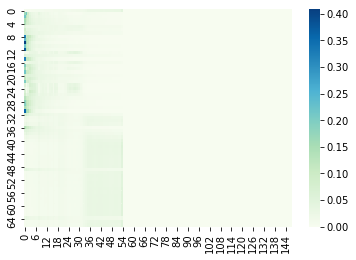

all_attentions shape : torch.Size([11, 67, 148])
prediciton : I can't remember where we can here they to see years ago.
Target :  -Yes! Hahahaha!
Distance Score: 41.763 
 Teacher Forcing : 0.05
epoch: 1
0.001
B: 1 / 70, avg_loss: 0.544, Time Taken : 0.414, 
 B: 11 / 70, avg_loss: 0.528, Time Taken : 0.384, 
 B: 21 / 70, avg_loss: 0.524, Time Taken : 0.397, 
 B: 31 / 70, avg_loss: 0.532, Time Taken : 0.432, 
 B: 41 / 70, avg_loss: 0.525, Time Taken : 0.366, 
 B: 51 / 70, avg_loss: 0.532, Time Taken : 0.335, 
 B: 61 / 70, avg_loss: 0.529, Time Taken : 0.319, 
 

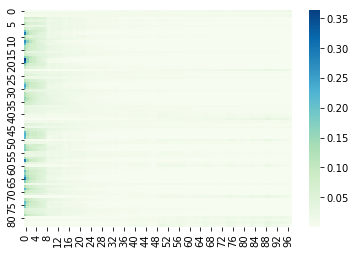

all_attentions shape : torch.Size([11, 84, 98])
prediciton : - What?! - Hey, Taki...
Target :  -Yes! Hahahaha!
Distance Score: 434.946 
 Teacher Forcing : 0.05
epoch: 2
0.001
B: 1 / 70, avg_loss: 0.413, Time Taken : 0.371, 
 B: 11 / 70, avg_loss: 0.482, Time Taken : 0.214, 
 B: 21 / 70, avg_loss: 0.487, Time Taken : 0.397, 
 B: 31 / 70, avg_loss: 0.488, Time Taken : 0.433, 
 B: 41 / 70, avg_loss: 0.483, Time Taken : 0.417, 
 B: 51 / 70, avg_loss: 0.486, Time Taken : 0.258, 
 B: 61 / 70, avg_loss: 0.497, Time Taken : 0.407, 
 

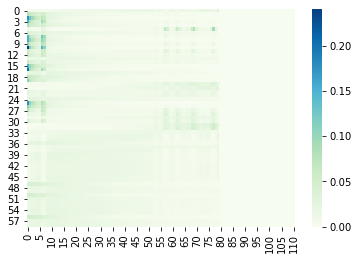

all_attentions shape : torch.Size([11, 59, 111])
prediciton : The comet.
Target :  -Yes! Hahahaha!
Distance Score: 43.676 
 Teacher Forcing : 0.05
epoch: 3
0.001
B: 1 / 70, avg_loss: 0.427, Time Taken : 0.421, 
 B: 11 / 70, avg_loss: 0.442, Time Taken : 0.405, 
 B: 21 / 70, avg_loss: 0.462, Time Taken : 0.230, 
 B: 31 / 70, avg_loss: 0.458, Time Taken : 0.345, 
 B: 41 / 70, avg_loss: 0.464, Time Taken : 0.287, 
 B: 51 / 70, avg_loss: 0.477, Time Taken : 0.378, 
 B: 61 / 70, avg_loss: 0.474, Time Taken : 0.411, 
 

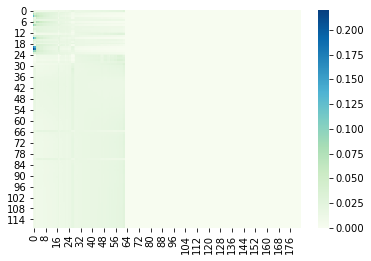

all_attentions shape : torch.Size([11, 119, 184])
prediciton : I didn't want to me some with the same and the festival.
Target :  -Yes! Hahahaha!
Distance Score: 171.309 
 Teacher Forcing : 0.05
epoch: 4
0.001
B: 1 / 70, avg_loss: 0.348, Time Taken : 0.425, 
 B: 11 / 70, avg_loss: 0.393, Time Taken : 0.359, 
 B: 21 / 70, avg_loss: 0.411, Time Taken : 0.325, 
 B: 31 / 70, avg_loss: 0.414, Time Taken : 0.288, 
 B: 41 / 70, avg_loss: 0.420, Time Taken : 0.290, 
 B: 51 / 70, avg_loss: 0.425, Time Taken : 0.385, 
 B: 61 / 70, avg_loss: 0.427, Time Taken : 0.435, 
 

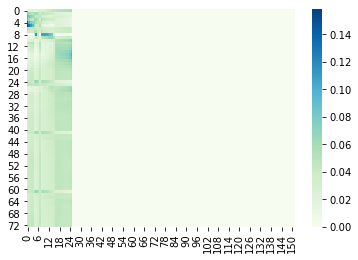

all_attentions shape : torch.Size([11, 73, 152])
prediciton : - Why got it. - Hey, I don't remember where the town!
Target :  -Yes! Hahahaha!
Distance Score: 128.953 
 Teacher Forcing : 0.05
epoch: 5
0.001
B: 1 / 70, avg_loss: 0.330, Time Taken : 0.397, 
 B: 11 / 70, avg_loss: 0.401, Time Taken : 0.319, 
 B: 21 / 70, avg_loss: 0.391, Time Taken : 0.394, 
 B: 31 / 70, avg_loss: 0.410, Time Taken : 0.328, 
 B: 41 / 70, avg_loss: 0.410, Time Taken : 0.251, 
 B: 51 / 70, avg_loss: 0.413, Time Taken : 0.303, 
 B: 61 / 70, avg_loss: 0.415, Time Taken : 0.280, 
 

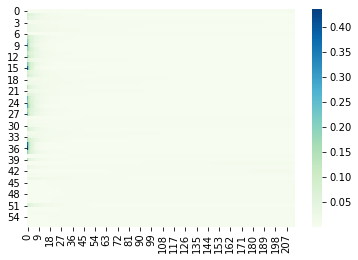

all_attentions shape : torch.Size([11, 57, 214])
prediciton : The number you are trying to tell you.
Target :  -Yes! Hahahaha!
Distance Score: 47.802 
 Teacher Forcing : 0.05
epoch: 6
0.001
B: 1 / 70, avg_loss: 0.330, Time Taken : 0.466, 
 B: 11 / 70, avg_loss: 0.354, Time Taken : 0.319, 
 B: 21 / 70, avg_loss: 0.349, Time Taken : 0.259, 
 B: 31 / 70, avg_loss: 0.369, Time Taken : 0.344, 
 B: 41 / 70, avg_loss: 0.374, Time Taken : 0.422, 
 B: 51 / 70, avg_loss: 0.377, Time Taken : 0.304, 
 B: 61 / 70, avg_loss: 0.384, Time Taken : 0.305, 
 

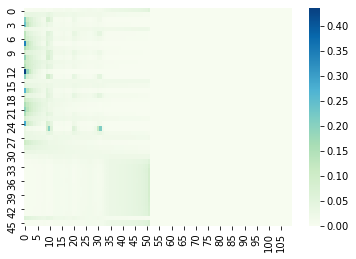

all_attentions shape : torch.Size([11, 46, 110])
prediciton : What is it?!
Target :  -Yes! Hahahaha!
Distance Score: 59.799 
 Teacher Forcing : 0.05
epoch: 7
0.001
B: 1 / 70, avg_loss: 0.334, Time Taken : 0.357, 
 B: 11 / 70, avg_loss: 0.379, Time Taken : 0.355, 
 B: 21 / 70, avg_loss: 0.348, Time Taken : 0.386, 
 B: 31 / 70, avg_loss: 0.350, Time Taken : 0.433, 
 B: 41 / 70, avg_loss: 0.350, Time Taken : 0.367, 
 B: 51 / 70, avg_loss: 0.352, Time Taken : 0.305, 
 B: 61 / 70, avg_loss: 0.360, Time Taken : 0.258, 
 

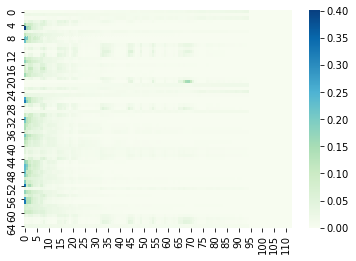

all_attentions shape : torch.Size([11, 65, 113])
prediciton : I was kind-of it became a date.
Target :  -Yes! Hahahaha!
Distance Score: 38.317 
 Teacher Forcing : 0.05
epoch: 8
0.001
B: 1 / 70, avg_loss: 0.245, Time Taken : 0.431, 
 B: 11 / 70, avg_loss: 0.268, Time Taken : 0.377, 
 B: 21 / 70, avg_loss: 0.277, Time Taken : 0.303, 
 B: 31 / 70, avg_loss: 0.283, Time Taken : 0.365, 
 B: 41 / 70, avg_loss: 0.289, Time Taken : 0.330, 
 B: 51 / 70, avg_loss: 0.288, Time Taken : 0.305, 
 B: 61 / 70, avg_loss: 0.294, Time Taken : 0.325, 
 

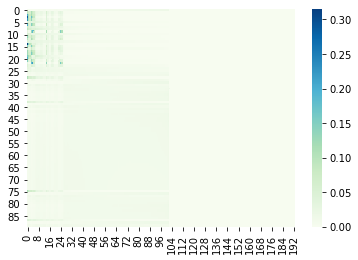

all_attentions shape : torch.Size([11, 90, 193])


In [ ]:
teacherForcingRate=[0.05,0.10,0.15,0.20]#No batchnorm aand SELU activation function
best_dis = 1000
for epoch in range(start_epoch,start_epoch+10):#New architecture with Encoder hidden dim=256 and Decoder hidden_dim=512 increased and encoder output increased
    
    tf=teacherForcingRate[0]
    if (epoch+1)>=15:
        tf=teacherForcingRate[1]
    if (epoch+1)>=30:
        tf=teacherForcingRate[2]
    if (epoch+1)>=42:
        tf=teacherForcingRate[3]
        
    print("Teacher Forcing :",tf)
    print("epoch:", epoch)
    for param_group in optimizer.param_groups:
        print(param_group['lr'])
    
    train(model, train_loader, criterion, optimizer, epoch,tf)
    dis = validation(model, valid_loader)
#     scheduler.step(dis)
    torch.save({'model_state': model.state_dict(), 'opti_state': optimizer.state_dict(), 'val_dis': dis}, "epoch"+str(epoch))
  

In [139]:
start_epoch=epoch
start_epoch

58

In [31]:
mn = torch.load("epoch33")
model.load_state_dict(mn['model_state'])
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(40, 256, batch_first=True, bidirectional=True)
    (pBLSTM1): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, dropout=0.2, bidirectional=True)
      (lockdrop): LockedDropout()
    )
    (pBLSTM2): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, dropout=0.2, bidirectional=True)
      (lockdrop): LockedDropout()
    )
    (pBLSTM3): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, dropout=0.2, bidirectional=True)
      (lockdrop): LockedDropout()
    )
    (key_network): Linear(in_features=512, out_features=256, bias=True)
    (value_network): Linear(in_features=512, out_features=256, bias=True)
    (lockdrop): LockedDropout()
  )
  (decoder): Decoder(
    (embedding): Embedding(34, 512, padding_idx=33)
    (lstm1): LSTMCell(768, 256)
    (lstm2): LSTMCell(256, 256)
    (attention): Attention()
    (character_prob): Linear(in_features=512, out_features=34, bias=True)
  )
)

In [32]:
test_dataset = Speech2TextDataset(speech_test, None, False)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_test)

In [34]:
epoch = 33
def test(model, test_loader):
    ### Write your test code here! ###
    total_dist_score=0
    model.eval()
    seq_len=0
    final_prediction=[]
    for batch_idx,(inp,inp_len) in enumerate(test_loader):
        start = time.time()
        inp,inp_len=inp.to(device),inp_len.to(device)
        output=model(epoch,batch_idx,None,inp, inp_len, None, False)
        
        pred=predictions(output.argmax(-1).detach().cpu().numpy())#We get back batch of characters
#         print(pred)
        for i in pred:
            final_prediction.append(i)
                
        del inp
        del inp_len
        stop = time.time()
        torch.cuda.empty_cache()
        print('B: %d / %d' % (batch_idx+1, len(test_loader)),end='\n ')
        
    return final_prediction

In [35]:
final_prediction=test(model, test_loader)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


B: 1 / 41
 B: 2 / 41
 B: 3 / 41
 B: 4 / 41
 B: 5 / 41
 B: 6 / 41
 B: 7 / 41
 B: 8 / 41
 B: 9 / 41
 B: 10 / 41
 B: 11 / 41
 B: 12 / 41
 B: 13 / 41
 B: 14 / 41
 B: 15 / 41
 B: 16 / 41
 B: 17 / 41
 B: 18 / 41
 B: 19 / 41
 B: 20 / 41
 B: 21 / 41
 B: 22 / 41
 B: 23 / 41
 B: 24 / 41
 B: 25 / 41
 B: 26 / 41
 B: 27 / 41
 B: 28 / 41
 B: 29 / 41
 B: 30 / 41
 B: 31 / 41
 B: 32 / 41
 B: 33 / 41
 B: 34 / 41
 B: 35 / 41
 B: 36 / 41
 B: 37 / 41
 B: 38 / 41
 B: 39 / 41
 B: 40 / 41
 B: 41 / 41
 

In [36]:
len(final_prediction)

2620

In [37]:
import pandas as pd
sample_csv=pd.read_csv('content/competitions/11785-spring2021-hw4p2/s21_sample.csv')

#We read in the sample csv and replace its last column with the scores we have achieved
n = sample_csv.columns[1]
sample_csv[n] = final_prediction

submission_csv=sample_csv

submission_csv.to_csv('submission2.csv',index=False) 